In [466]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import seaborn as sns
import datetime 
from datetime import date
from datetime import *; from dateutil.relativedelta import *
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.9f' % x)
np.set_printoptions(suppress=True)

In [467]:
import pydata_google_auth
credentials = pydata_google_auth.get_user_credentials(
    ['https://www.googleapis.com/auth/bigquery'],
)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=262006177488-3425ks60hkk80fssi9vpohv88g6q1iqd.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=9vUYxHDdklZBH9PLAxizec9xFGQGAg&access_type=offline


In [468]:
client = bigquery.Client(project = 'etsy-bigquery-adhoc-prod', credentials=credentials)

In [469]:
#add code for `etsy-data-warehouse-dev.tnormil.offsite_ads_chargeability` 
#data last updated on 08/04/2022


# sql = """
# with base as
#         (select order_date,
#                 top_channel,
#                 second_channel,
#                 #third_channel,
#                 #utm_campaign,
#                 #utm_medium,
#                 mapped_region,
#       sum(attr_gms) AS attr_gms,
#       sum(attr_receipt) as attr_receipt,
#       #sum(attr_rev) as attr_rev,
#       sum(chargeable_attr_gms) as chargeable_attr_gms,
#       sum(chargeable_attr_receipt) as chargeable_attr_receipt,
#       #sum(chargeable_attr_rev) as chargeable_attr_rev,
#       sum(chargeable_gms) as chargeable_gms,
#       sum(chargeable_receipts) as chargeable_receipts,
#       sum(advertising_revenue) as advertising_revenue
#       from `etsy-data-warehouse-dev.tnormil.offsite_ads_chargeability` 
#       group by 1,2,3,4)
# SELECT * EXCEPT (order_date) ,
# '' as flag,
# order_date
# FROM base osa
# UNION ALL
# SELECT * EXCEPT (order_date) ,
# '_dly' as flag,
# datetime_add(osa.order_date, interval 52 WEEK) AS order_date,
# FROM base osa
# WHERE datetime_add(order_date, interval 52 WEEK) < CAST(current_date() as DATETIME)
# union all
# SELECT * EXCEPT (order_date) ,
# '_d2ly' as flag,
# datetime_add(osa.order_date, interval 104 WEEK) AS order_date,
# FROM base osa
# WHERE datetime_add(order_date, interval 104 WEEK) < CAST(current_date() as DATETIME)
# union all
# SELECT * EXCEPT (order_date) ,
# '_d3ly' as flag,
# datetime_add(osa.order_date, interval 156 WEEK) AS order_date,
# FROM base osa
# WHERE datetime_add(order_date, interval 156 WEEK) < CAST(current_date() as DATETIME)
# """

sql = """
with base as
        (select order_date,
        date_trunc(order_date, year) as order_year, 
        extract(week from order_date) as order_week_num, 
        extract(dayofyear from order_date) as order_dayofyear, 
        reporting_channel_group,
        engine,
      sum(attr_gms) AS attr_gms,
      sum(attr_receipt) as attr_receipt,
      sum(attr_rev) as attr_rev,
      sum(chargeable_gms) as chargeable_gms,
      sum(chargeable_receipts) as chargeable_receipts,
      sum(advertising_revenue) as advertising_revenue
      from `etsy-data-warehouse-dev.tnormil.offsite_ads_chargeability` 
      left join `etsy-data-warehouse-prod.buyatt_mart.channel_dimensions` cd using (utm_campaign, utm_medium, top_channel, second_channel, third_channel)
      where order_date <= '2022-07-01'
      group by 1,2,3,4,5,6)
SELECT * EXCEPT (order_date) ,
'' as flag,
order_date
FROM base osa
UNION ALL
SELECT * EXCEPT (order_date) ,
'_dly' as flag,
datetime_add(osa.order_date, interval 52 WEEK) AS order_date,
FROM base osa
WHERE datetime_add(order_date, interval 52 WEEK) < CAST(current_date() as DATETIME)
union all
SELECT * EXCEPT (order_date) ,
'_d2ly' as flag,
datetime_add(osa.order_date, interval 104 WEEK) AS order_date,
FROM base osa
WHERE datetime_add(order_date, interval 104 WEEK) < CAST(current_date() as DATETIME)
union all
SELECT * EXCEPT (order_date) ,
'_d3ly' as flag,
datetime_add(osa.order_date, interval 156 WEEK) AS order_date,
FROM base osa
WHERE datetime_add(order_date, interval 156 WEEK) < CAST(current_date() as DATETIME)
"""

query_job = client.query(sql)
results = query_job.result()
base = results.to_dataframe()

In [470]:
base['order_date'] = pd.to_datetime(base['order_date']).dt.date
base['order_year'] = pd.to_datetime(base['order_year']).dt.date

base = pd.concat( [base[['order_date','flag']], base.drop(columns=['order_date','flag'])], axis = 1)

base.head()


,order_date,flag,order_year,order_week_num,order_dayofyear,reporting_channel_group,engine,attr_gms,attr_receipt,attr_rev,chargeable_gms,chargeable_receipts,advertising_revenue
0,2022-05-11,_d2ly,2020-01-01,19,134,PLA,Google - Paid,5171929.167268757,180355.206587323,1124730.811332733,3056517.790000000,92441.000000000,434418.199999999
1,2022-08-12,_d2ly,2020-01-01,32,227,PLA,Google - Paid,3391685.141781938,114396.349083486,715314.872218936,2010206.990000000,56986.000000000,277205.140000000
2,2022-02-13,_d2ly,2020-01-01,7,47,PLA,Google - Paid,1537123.019227284,47005.057389440,249961.572206358,994778.000000000,28125.000000000,166226.100000000
3,2022-06-02,_d2ly,2020-01-01,22,156,PLA,Bing - Paid,203025.316557980,7443.197424918,47855.019100979,99318.390000000,3238.000000000,14074.550000000
4,2022-06-24,_d2ly,2020-01-01,25,178,PLA,Bing - Paid,157233.842092143,6223.797064686,37963.794849983,82303.220000000,2776.000000000,11826.340000000


In [473]:
#add code for `etsy-data-warehouse-dev.tnormil.charge_lt_mta` 
#data last updated on 08/11/2022
#use this feature to predict chargeability pre May 2022 due to increased discreptancy between est receipts lt and mta and the truth values
#add link to validation charts

sql = """
with receipts_lt as
    (select date as order_date, date_trunc(date, year) as order_year,  extract(week from date) as order_week_num,  reporting_channel_group, engine, 
    count(distinct case when attr_receipt_osa_channel > 0 then receipt_id end) as receipts_lt
    FROM `etsy-data-warehouse-dev.tnormil.charge_lt_mta2` 
    where charged_osa = 1 
    group by 1,2,3,4,5),
attr_receipt as
    (SELECT date as order_date, reporting_channel_group, engine,
    sum(coalesce(attr_receipt_osa_channel,0)) as attr_receipt_osa_channel, 
    sum(coalesce(attr_receipt,0)) as attr_receipt,
    count(distinct receipt_id) as receipts_mta 
    FROM `etsy-data-warehouse-dev.tnormil.charge_lt_mta2` 
    where charged_osa = 1 
    group by 1,2,3)  
select a.*, b.receipts_mta, '' as flag
#b.attr_receipt_osa, b.attr_receipt, 
from receipts_lt a
left join attr_receipt b using (order_date, reporting_channel_group, engine)
#where b.attr_receipt_osa <> b.attr_receipt;
"""

query_job = client.query(sql)
results = query_job.result()
base_lt_mta_ratio = results.to_dataframe()

In [474]:
base_lt_mta_ratio['order_date'] = pd.to_datetime(base_lt_mta_ratio['order_date']).dt.date
base_lt_mta_ratio['order_year'] = pd.to_datetime(base_lt_mta_ratio['order_year']).dt.date

base_lt_mta_ratio.head()

,order_date,order_year,order_week_num,reporting_channel_group,engine,receipts_lt,receipts_mta,flag
0,2021-10-16,2021-01-01,41,Paid Social,Facebook - Paid,2162,3264,
1,2020-09-01,2020-01-01,35,Paid Social,Facebook - Paid,1436,4175,
2,2021-07-22,2021-01-01,29,Paid Social,Facebook - Paid,1999,3228,
3,2022-03-09,2022-01-01,10,Paid Social,Facebook - Paid,2956,5465,
4,2022-06-13,2022-01-01,24,Paid Social,Facebook - Paid,1446,2837,


In [490]:
sql = """
SELECT '' as flag, reporting_channel_group, engine, 
date_trunc(date, year) as order_year,  extract(week from date) as order_week_num, date as order_date,
avg(case when charged_osa = 1 then attr_receipt_osa_channel end) as attr_receipt_osa_channel_avg, avg(attr_receipt) as attr_receipt_avg,
stddev(case when charged_osa = 1 then attr_receipt_osa_channel end) as attr_receipt_osa_channel_stddev, stddev(attr_receipt) as attr_receipt_stddev,
FROM `etsy-data-warehouse-dev.tnormil.charge_lt_mta2`
group by 1,2,3,4,5,6;
"""

query_job = client.query(sql)
results = query_job.result()
credit = results.to_dataframe()

In [491]:
credit_base = credit.copy()

In [492]:
credit_base.head(2)

,flag,reporting_channel_group,engine,order_year,order_week_num,order_date,attr_receipt_osa_channel_avg,attr_receipt_avg,attr_receipt_osa_channel_stddev,attr_receipt_stddev
0,,Display,Other Paid,2020-01-01,1,2020-01-10,NaN,0.114253774,NaN,0.200232366
1,,Display,Other Paid,2020-01-01,11,2020-03-15,NaN,0.062293673,NaN,0.094882376


In [551]:
sql = """
with base as 
(select *, case when date_diff(date, first_visit_date, DAY) <= 15 then '1 - 15' else '15+' end as days_since_purchase_type
from `etsy-data-warehouse-dev.tnormil.charge_lt_mta` )
select '' as flag, date as order_date, reporting_channel_group, engine, days_since_purchase_type, 
count(receipt_id) as receipts, avg(date_diff(date, first_visit_date, DAY)) AS days_since_purchase,
stddev(date_diff(date, first_visit_date, DAY)) AS days_since_purchase_stddev,
from base
group by 1,2,3,4,5
"""

query_job = client.query(sql)
results = query_job.result()
days_to_purch = results.to_dataframe()

In [554]:
metrics_index = (days_to_purch.columns.values.tolist()).index("receipts")
group_by_col = (days_to_purch.columns.values.tolist())[:metrics_index ]
metrics = (days_to_purch.columns.values.tolist())[metrics_index:]

print(group_by_col)
print(metrics)

days_to_purch[metrics] = days_to_purch[metrics].astype(float)

days_to_purch_base = pd.pivot_table(days_to_purch, values=metrics, index=[item for item in group_by_col if item != 'days_since_purchase_type'],
                    columns=['days_since_purchase_type'])

days_to_purch_base.columns = days_to_purch_base.columns.map('_'.join).str.strip('_')

days_to_purch_base.fillna(0, inplace=True)

days_to_purch_base['pct_receipts_1 - 15'] = days_to_purch_base['receipts_1 - 15']/(days_to_purch_base['receipts_1 - 15']+days_to_purch_base['receipts_15+'])

days_to_purch_base.drop(columns=['receipts_1 - 15','receipts_15+'], inplace=True)

days_to_purch_base.reset_index(inplace=True)

['flag', 'order_date', 'reporting_channel_group', 'engine', 'days_since_purchase_type']
['receipts', 'days_since_purchase', 'days_since_purchase_stddev']


In [555]:
days_to_purch_base.head()

,flag,order_date,reporting_channel_group,engine,days_since_purchase_1 - 15,days_since_purchase_15+,days_since_purchase_stddev_1 - 15,days_since_purchase_stddev_15+,pct_receipts_1 - 15
0,,2020-01-01,Affiliates,Affiliates,0.000000000,0.000000000,0.000000000,0.000000000,1.000000000
1,,2020-01-01,Display,Google - Paid,0.000000000,0.000000000,0.000000000,0.000000000,1.000000000
2,,2020-01-01,Display,Other Paid,0.000000000,0.000000000,0.000000000,0.000000000,1.000000000
3,,2020-01-01,PLA,Bing - Paid,0.000000000,0.000000000,0.000000000,0.000000000,1.000000000
4,,2020-01-01,PLA,Google - Paid,0.000000000,0.000000000,0.000000000,0.000000000,1.000000000


In [ ]:
sql = """
(with clicks as 
(select date(start_datetime) as date, count(visit_id) as visits 
from  `etsy-data-warehouse-prod.buyatt_mart.visits_vw` v 
left join `etsy-data-warehouse-prod.buyatt_mart.channel_dimensions` cd using (utm_campaign, utm_medium, top_channel, second_channel, third_channel)
where v._date >= '2020-01-01' 
and (v.second_channel IN(
'gpla', 'intl_gpla', 'facebook_disp', 'bing_plas', 'intl_bing_plas', 'pinterest_disp', 'pinterest_disp_intl','instagram_disp', 'facebook_disp_intl', 'affiliates'
) or (v.second_channel in ('native_display','intl_native_display') and third_channel not like '%msan%'))
and reporting_channel_group in ('PLA', 'Display', 'Paid Social', 'Affiliates') 
group by 1),
osa_el_clicks as 
(select date(timestamp_seconds(click_date)) as date,
count(click_id) as osa_el_clicks,
count(distinct listing_id) as osa_el_listings,
count(distinct shop_id) as osa_el_shops
from etsy-data-warehouse-prod.etsy_shard.ads_attribution_clicks 
group by 1)
select a.date, visits, osa_el_clicks, osa_el_listings, osa_el_shops
from clicks a
full outer join osa_el_clicks b using (date));
"""

query_job = client.query(sql)
results = query_job.result()
osa_el_clicks = results.to_dataframe()

In [556]:
channel_base_ratio = base.merge(base_lt_mta_ratio, on=['flag', 'order_date','order_year','order_week_num','reporting_channel_group','engine'], how="outer")

channel_base_ratio = channel_base_ratio.merge(credit_base, on=['flag', 'order_year','order_week_num','order_date','reporting_channel_group','engine'], how="outer")

channel_base_ratio = channel_base_ratio.merge(days_to_purch_base, on=['flag', 'order_date','reporting_channel_group','engine'], how="outer")

channel_base_ratio.head()

,order_date,flag,order_year,order_week_num,order_dayofyear,reporting_channel_group,engine,attr_gms,attr_receipt,attr_rev,chargeable_gms,chargeable_receipts,advertising_revenue,receipts_lt,receipts_mta,attr_receipt_osa_channel_avg,attr_receipt_avg,attr_receipt_osa_channel_stddev,attr_receipt_stddev,days_since_purchase_1 - 15,days_since_purchase_15+,days_since_purchase_stddev_1 - 15,days_since_purchase_stddev_15+,pct_receipts_1 - 15
0,2022-05-11,_d2ly,2020-01-01,19,134,PLA,Google - Paid,5171929.167268757,180355.206587323,1124730.811332733,3056517.790000000,92441.000000000,434418.199999999,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-08-12,_d2ly,2020-01-01,32,227,PLA,Google - Paid,3391685.141781938,114396.349083486,715314.872218936,2010206.990000000,56986.000000000,277205.140000000,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-02-13,_d2ly,2020-01-01,7,47,PLA,Google - Paid,1537123.019227284,47005.057389440,249961.572206358,994778.000000000,28125.000000000,166226.100000000,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-06-02,_d2ly,2020-01-01,22,156,PLA,Bing - Paid,203025.316557980,7443.197424918,47855.019100979,99318.390000000,3238.000000000,14074.550000000,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-06-24,_d2ly,2020-01-01,25,178,PLA,Bing - Paid,157233.842092143,6223.797064686,37963.794849983,82303.220000000,2776.000000000,11826.340000000,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [557]:
metrics_index = (channel_base_ratio.columns.values.tolist()).index("attr_gms")
group_by_col = (channel_base_ratio.columns.values.tolist())[:metrics_index ]
metrics = (channel_base_ratio.columns.values.tolist())[metrics_index:]

print(group_by_col)
print(metrics)

channel_base_ratio[metrics] = channel_base_ratio[metrics].astype(float)

['order_date', 'flag', 'order_year', 'order_week_num', 'order_dayofyear', 'reporting_channel_group', 'engine']
['attr_gms', 'attr_receipt', 'attr_rev', 'chargeable_gms', 'chargeable_receipts', 'advertising_revenue', 'receipts_lt', 'receipts_mta', 'attr_receipt_osa_channel_avg', 'attr_receipt_avg', 'attr_receipt_osa_channel_stddev', 'attr_receipt_stddev', 'days_since_purchase_1 - 15', 'days_since_purchase_15+', 'days_since_purchase_stddev_1 - 15', 'days_since_purchase_stddev_15+', 'pct_receipts_1 - 15']


In [558]:
channel_base_ratio.head()

,order_date,flag,order_year,order_week_num,order_dayofyear,reporting_channel_group,engine,attr_gms,attr_receipt,attr_rev,chargeable_gms,chargeable_receipts,advertising_revenue,receipts_lt,receipts_mta,attr_receipt_osa_channel_avg,attr_receipt_avg,attr_receipt_osa_channel_stddev,attr_receipt_stddev,days_since_purchase_1 - 15,days_since_purchase_15+,days_since_purchase_stddev_1 - 15,days_since_purchase_stddev_15+,pct_receipts_1 - 15
0,2022-05-11,_d2ly,2020-01-01,19,134,PLA,Google - Paid,5171929.167268757,180355.206587323,1124730.811332733,3056517.790000000,92441.000000000,434418.199999999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-08-12,_d2ly,2020-01-01,32,227,PLA,Google - Paid,3391685.141781938,114396.349083486,715314.872218936,2010206.990000000,56986.000000000,277205.140000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-02-13,_d2ly,2020-01-01,7,47,PLA,Google - Paid,1537123.019227284,47005.057389440,249961.572206358,994778.000000000,28125.000000000,166226.100000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-06-02,_d2ly,2020-01-01,22,156,PLA,Bing - Paid,203025.316557980,7443.197424918,47855.019100979,99318.390000000,3238.000000000,14074.550000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-06-24,_d2ly,2020-01-01,25,178,PLA,Bing - Paid,157233.842092143,6223.797064686,37963.794849983,82303.220000000,2776.000000000,11826.340000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [559]:
channel_base_ratio['chargeability'] = (channel_base_ratio['chargeable_gms']/channel_base_ratio['attr_gms'] * 100).astype(float)
channel_base_ratio['aov'] = (channel_base_ratio['attr_gms']/channel_base_ratio['attr_receipt']).astype(float) 
channel_base_ratio['chargeable_aov'] = (channel_base_ratio['chargeable_gms']/channel_base_ratio['chargeable_receipts']).astype(float)
channel_base_ratio['receipts_lt_mta'] = (channel_base_ratio['receipts_lt']/channel_base_ratio['receipts_mta']).astype(float)

base_yoy = channel_base_ratio[channel_base_ratio['flag'] == ''].copy()

for i in channel_base_ratio['flag'].drop_duplicates():

    print(i)

    if i != '':

        join_df = channel_base_ratio[channel_base_ratio['flag'] == i]

        metrics_index = (channel_base_ratio.columns.values.tolist()).index("attr_gms")
        group_by_col = (channel_base_ratio.columns.values.tolist())[:metrics_index ]
        metrics = (channel_base_ratio.columns.values.tolist())[metrics_index:]

        join_df.columns = group_by_col + [item + i for item in metrics]

        #join on order_date only
        base_yoy = base_yoy.merge(join_df.loc[:, ~join_df.columns.isin(['flag','order_week_num','order_year','order_dayofyear'])], how='left', 
            on=[ item for item in group_by_col if item not in ['flag','order_week_num','order_year','order_dayofyear'] ])
        
        print(base_yoy)
        
        for metric in ['aov','chargeable_aov','attr_gms','chargeable_gms','advertising_revenue']:

            base_yoy[metric + i + '_yoy'] = (base_yoy[metric]/base_yoy[metric + i] * 100).astype(float) 
            
            if metric == 'chargeable_aov':
                
                base_yoy[metric + i + '_yoy_diff'] = base_yoy[metric + i + '_yoy'] - base_yoy['aov' + i + '_yoy']
                
            
channel_base_ratio_yoy = base_yoy

channel_base_ratio_yoy.drop(columns=['flag'], inplace=True)


_d2ly
      order_date flag  order_year  order_week_num  order_dayofyear  \
0     2021-09-07       2021-01-01              36              250   
1     2021-11-25       2021-01-01              47              329   
2     2020-05-10       2020-01-01              19              131   
3     2020-07-17       2020-01-01              28              199   
4     2020-08-07       2020-01-01              31              220   
...          ...  ...         ...             ...              ...   
7596  2022-08-08              NaN            <NA>             <NA>   
7597  2022-08-09              NaN            <NA>             <NA>   
7598  2022-08-09              NaN            <NA>             <NA>   
7599  2022-08-10              NaN            <NA>             <NA>   
7600  2022-08-10              NaN            <NA>             <NA>   

     reporting_channel_group         engine          attr_gms  \
0                        PLA  Google - Paid 4214712.251201287   
1                      

In [560]:
channel_base_ratio_yoy[channel_base_ratio_yoy['order_date']==date(2022,6, 1)].head(20)

,order_date,order_year,order_week_num,order_dayofyear,reporting_channel_group,engine,attr_gms,attr_receipt,attr_rev,chargeable_gms,chargeable_receipts,advertising_revenue,receipts_lt,receipts_mta,attr_receipt_osa_channel_avg,attr_receipt_avg,attr_receipt_osa_channel_stddev,attr_receipt_stddev,days_since_purchase_1 - 15,days_since_purchase_15+,days_since_purchase_stddev_1 - 15,days_since_purchase_stddev_15+,pct_receipts_1 - 15,chargeability,aov,chargeable_aov,receipts_lt_mta,attr_gms_d2ly,attr_receipt_d2ly,attr_rev_d2ly,chargeable_gms_d2ly,chargeable_receipts_d2ly,advertising_revenue_d2ly,receipts_lt_d2ly,receipts_mta_d2ly,attr_receipt_osa_channel_avg_d2ly,attr_receipt_avg_d2ly,attr_receipt_osa_channel_stddev_d2ly,attr_receipt_stddev_d2ly,days_since_purchase_1 - 15_d2ly,days_since_purchase_15+_d2ly,days_since_purchase_stddev_1 - 15_d2ly,days_since_purchase_stddev_15+_d2ly,pct_receipts_1 - 15_d2ly,chargeability_d2ly,aov_d2ly,chargeable_aov_d2ly,receipts_lt_mta_d2ly,aov_d2ly_yoy,chargeable_aov_d2ly_yoy,chargeable_aov_d2ly_yoy_diff,attr_gms_d2ly_yoy,chargeable_gms_d2ly_yoy,advertising_revenue_d2ly_yoy,attr_gms_dly,attr_receipt_dly,attr_rev_dly,chargeable_gms_dly,chargeable_receipts_dly,advertising_revenue_dly,receipts_lt_dly,receipts_mta_dly,attr_receipt_osa_channel_avg_dly,attr_receipt_avg_dly,attr_receipt_osa_channel_stddev_dly,attr_receipt_stddev_dly,days_since_purchase_1 - 15_dly,days_since_purchase_15+_dly,days_since_purchase_stddev_1 - 15_dly,days_since_purchase_stddev_15+_dly,pct_receipts_1 - 15_dly,chargeability_dly,aov_dly,chargeable_aov_dly,receipts_lt_mta_dly,aov_dly_yoy,chargeable_aov_dly_yoy,chargeable_aov_dly_yoy_diff,attr_gms_dly_yoy,chargeable_gms_dly_yoy,advertising_revenue_dly_yoy
3149,2022-06-01,2022-01-01,22,152,Paid Social,Facebook - Paid,188204.452262399,5774.853094845,33896.248807415,85399.770000000,1612.000000000,10823.150000000,1612.000000000,3089.000000000,0.588891319,0.146764753,0.355437607,0.198592865,7.264256000,23.845654556,4.894600088,4.229081848,0.397067419,45.376062560,32.590344580,52.977524814,0.521851732,165282.950655910,5287.731002503,23995.972359404,17298.400000000,254.000000000,2057.720000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.465931260,31.257821281,68.103937008,NaN,104.263007610,77.789225031,-26.473782579,113.868037517,493.685947833,525.977781234,325307.065512500,9698.589119880,52448.705787660,77520.100000000,1387.000000000,9831.950000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.829823640,33.541689569,55.890483057,NaN,97.163693897,94.788096141,-2.375597756,57.854400416,110.164679870,110.081418233
3281,2022-06-01,2022-01-01,22,152,None,None,388780.401129669,11314.083583959,67547.108842242,409.390000000,7.000000000,53.150000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.105301090,34.362518028,58.484285714,NaN,363135.254634504,13147.433471245,62667.612742232,0.000000000,0.000000000,0.000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000000,27.620238994,NaN,NaN,124.410646975,NaN,NaN,107.062147276,inf,inf,352541.271384162,10108.426206083,53501.224506298,1221.390000000,20.000000000,158.490000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.346453054,34.875980118,61.069500000,NaN,98.527748647,95.766766904,-2.760981743,110.279400651,33.518368416,33.535238816
3686,2022-06-01,2022-01-01,22,152,Display,Google - Paid,49011.684722156,1489.306015648,9258.586832047,4594.190000000,109.000000000,607.630000000,109.000000000,1271.000000000,0.427053376,0.085081591,0.307766697,0.121982595,7.653217627,22.877054874,4.599564200,4.156839386,0.506710068,9.373662681,32.909075910,42.148532110,0.085759245,7831.063595993,307.583629870,1348.871195908,0.000000000,0.000000000,0.000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000000,25.459949215,NaN,NaN,129.258215056,NaN,NaN,625.862427515,inf,inf,49481.439330201,1282.717466085,9108.326629955,41554.220000000,615.000000000,4888.950000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.979408365,38.575477951,67.567837398,NaN,85.310870164,

In [499]:
#VALIDATION PERFORMANCE NUMBERS
channel_base_ratio_yoy.sum()

/var/folders/s4/cq5d3lfd0r924yl4wwd0g0j80000gn/T/ipykernel_11405/818477172.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  channel_base_ratio_yoy.sum()


order_week_num                    170634.000000000
order_dayofyear                  1119961.000000000
attr_gms                      4697026548.524703979
attr_receipt                   148419449.146258205
attr_rev                       937338669.630999446
                                      ...         
chargeable_aov_dly_yoy            245174.491982390
chargeable_aov_dly_yoy_diff        10233.827652883
attr_gms_dly_yoy                 1238101.682511246
chargeable_gms_dly_yoy                         inf
advertising_revenue_dly_yoy                    inf
Length: 71, dtype: float64

In [562]:
channel_base_ratio_yoy['reporting_channel_group_engine'] = channel_base_ratio_yoy['reporting_channel_group'] + ' - ' + channel_base_ratio_yoy['engine']


Display - Google - Paid


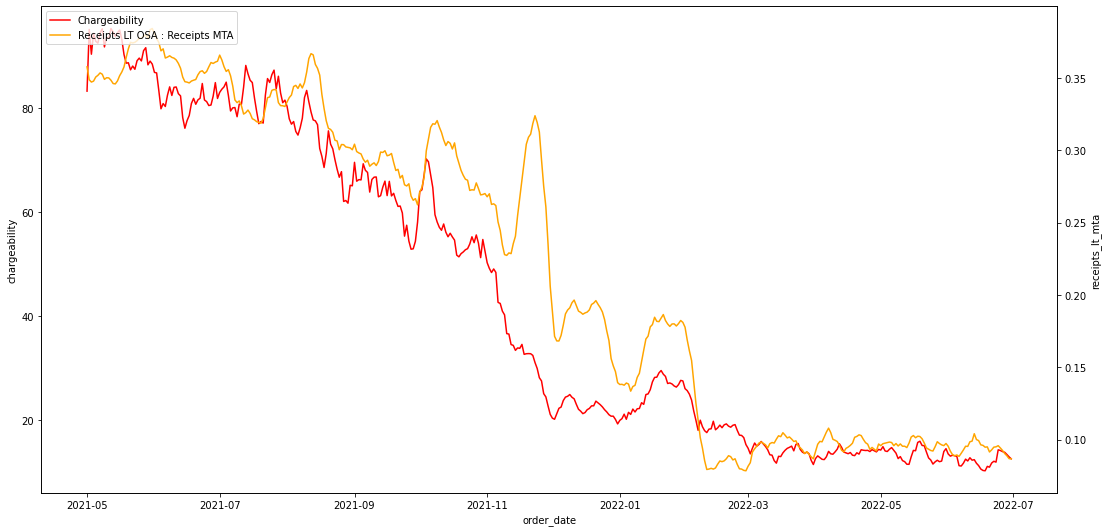

Paid Social - Pinterest - Paid


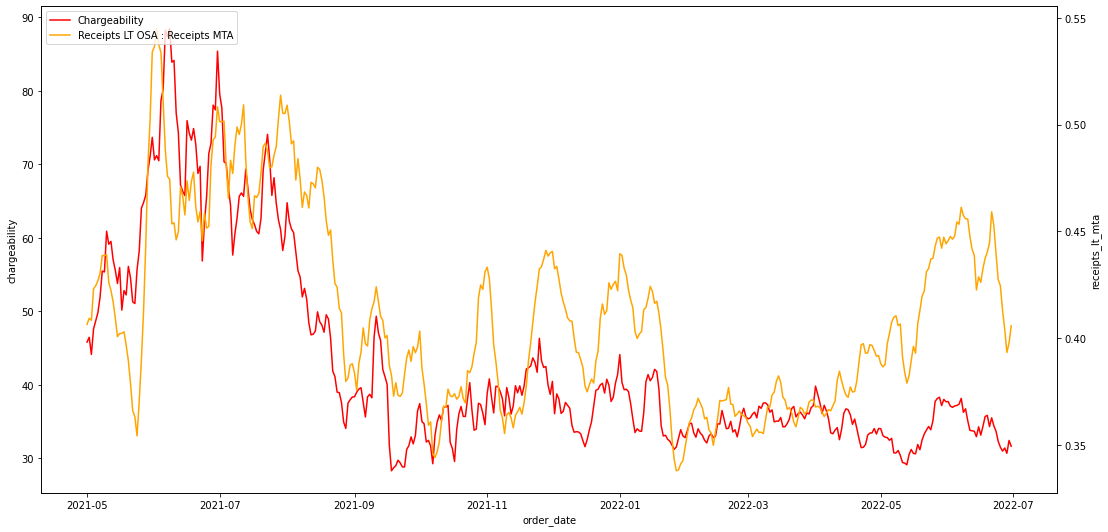

In [581]:
#Display/Pinterest Decel in 2021
#Chargeability vs Receipts_LT_MTA

plt.rcParams["figure.figsize"] = [15.50, 7.50]
plt.rcParams["figure.autolayout"] = True
    
for i in ['Display - Google - Paid', 'Paid Social - Pinterest - Paid']:
    
    viz_data = channel_base_ratio_yoy[(channel_base_ratio_yoy['reporting_channel_group_engine'] == i)&(channel_base_ratio_yoy['order_date']>= date.today() - relativedelta(months=18))
    &(channel_base_ratio_yoy['order_date'] < date(2022,7,1))&(channel_base_ratio_yoy['order_date'] >= date(2021,5,1))]
    
    viz_data = viz_data.sort_values(by=['reporting_channel_group_engine','order_date'])
    
    viz_data['moving_chargeability'] = viz_data.groupby('reporting_channel_group')['chargeability'].transform(lambda x: x.rolling(7, 1).mean())

    viz_data['moving_receipts_lt_mta'] = viz_data.groupby('reporting_channel_group')['receipts_lt_mta'].transform(lambda x: x.rolling(7, 1).mean())

    print(i)
        
    ax1 = plt.subplot()
    l1, = ax1.plot(viz_data['order_date'].array, viz_data['moving_chargeability'].array, color='red')
    ax2 = ax1.twinx()
    l2, = ax2.plot(viz_data['order_date'].array, viz_data['moving_receipts_lt_mta'].array, color='orange')
    
    plt.legend([l1, l2], ["Chargeability", "Receipts LT OSA : Receipts MTA"], loc='upper left')
        
    ax1.set_xlabel('order_date')
    ax1.set_ylabel('chargeability')
    ax2.set_ylabel('receipts_lt_mta')

    plt.show()

Display - Google - Paid


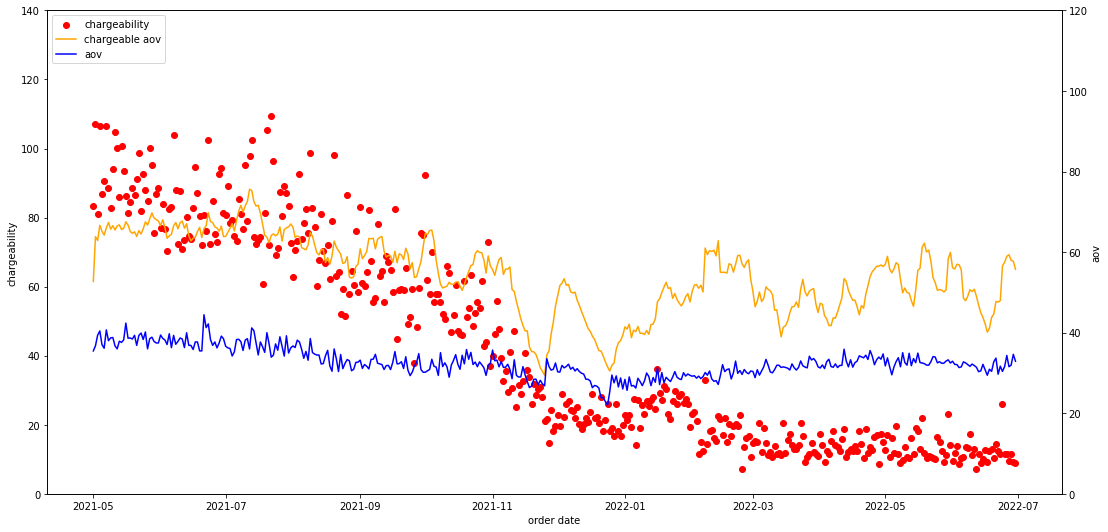

Paid Social - Pinterest - Paid


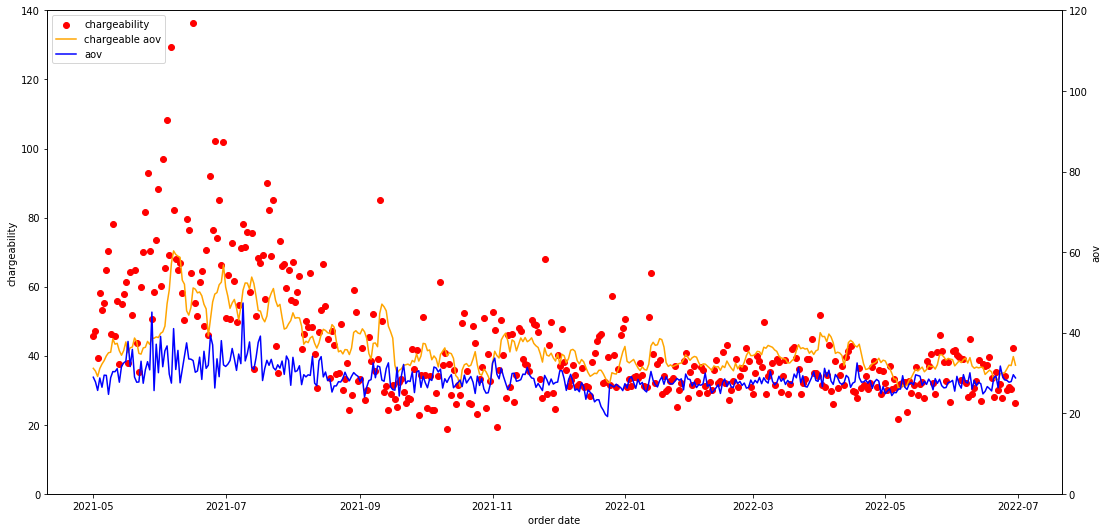

In [573]:
#Display/Pinterest Decel in 2021
#Chargeability vs AOV/Chargeable AOV
#SHOW

plt.rcParams["figure.figsize"] = [15.50, 7.50]
plt.rcParams["figure.autolayout"] = True

for i in ['Display - Google - Paid', 'Paid Social - Pinterest - Paid']:

    viz_data = channel_base_ratio_yoy[(channel_base_ratio_yoy['reporting_channel_group_engine'] == i)&(channel_base_ratio_yoy['order_date']>= date.today() - relativedelta(months=18))
    &(channel_base_ratio_yoy['order_date'] < date(2022,7,1))&(channel_base_ratio_yoy['order_date'] >= date(2021,5,1))]     
    
    viz_data = viz_data.sort_values(by=['reporting_channel_group_engine','order_date'])
    
    viz_data['moving_chargeable_aov'] = viz_data.groupby('reporting_channel_group')['chargeable_aov'].transform(lambda x: x.rolling(7, 1).mean())
 
    #viz_data['pct ''] = viz_data.groupby('reporting_channel_group')['chargeable_aov'].transform(lambda x: x.rolling(7, 1).mean())


    print(i)
    
    ax1 = plt.subplot()
    l1 = ax1.scatter(viz_data['order_date'].array, viz_data['chargeability'].array, color='red')
    
    ax2 = ax1.twinx()
    l2, = ax2.plot(viz_data['order_date'].array, viz_data['moving_chargeable_aov'].array, color='orange')
    l3, = ax2.plot(viz_data['order_date'].array, viz_data['aov'].array, color='blue')
    
    plt.legend([l1, l2,l3], ["chargeability", "chargeable aov","aov"], loc='upper left')
    
    ax1.set_xlabel('order date')
    ax1.set_ylabel('chargeability')
    ax2.set_ylabel('aov')
    
    ax1.set_ylim([0, 140])
    ax2.set_ylim([0, 120])
    
    plt.show()

Display - Google - Paid


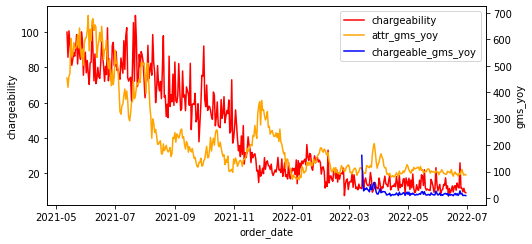

Paid Social - Pinterest - Paid


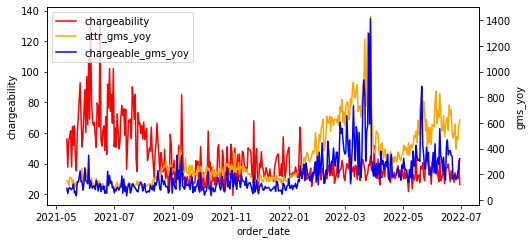

In [369]:
#Display/Pinterest Decel in 2021
#Chargeability vs Att GMS YOY

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

for i in ['Display - Google - Paid', 'Paid Social - Pinterest - Paid']:

    viz_data = base_yoy[(base_yoy['reporting_channel_group_engine'] == i)&(base_yoy['order_date']>= date.today() - relativedelta(months=15))
    &(base_yoy['order_date'] < date(2022,7,1))&(base_yoy['order_date'] >= date(2021,5,1))]       
    
    viz_data = viz_data.sort_values(by=['reporting_channel_group_engine','order_date'])
        
    print(i)
    
    ax1 = plt.subplot()
    l1, = ax1.plot(viz_data['order_date'].array, viz_data['chargeability'].array, color='red')    
    ax2 = ax1.twinx()
    l2, = ax2.plot(viz_data['order_date'].array, viz_data['attr_gms_dly_yoy'].array, color='orange')
    l3, = ax2.plot(viz_data['order_date'].array, viz_data['chargeable_gms_dly_yoy'].array, color='blue')
    
    plt.legend([l1, l2,l3], ["chargeability", "attr_gms_yoy","chargeable_gms_yoy"])
    
    ax1.set_xlabel('order_date')
    ax1.set_ylabel('chargeability')
    ax2.set_ylabel('gms_yoy')

    plt.show()

Display - Google - Paid


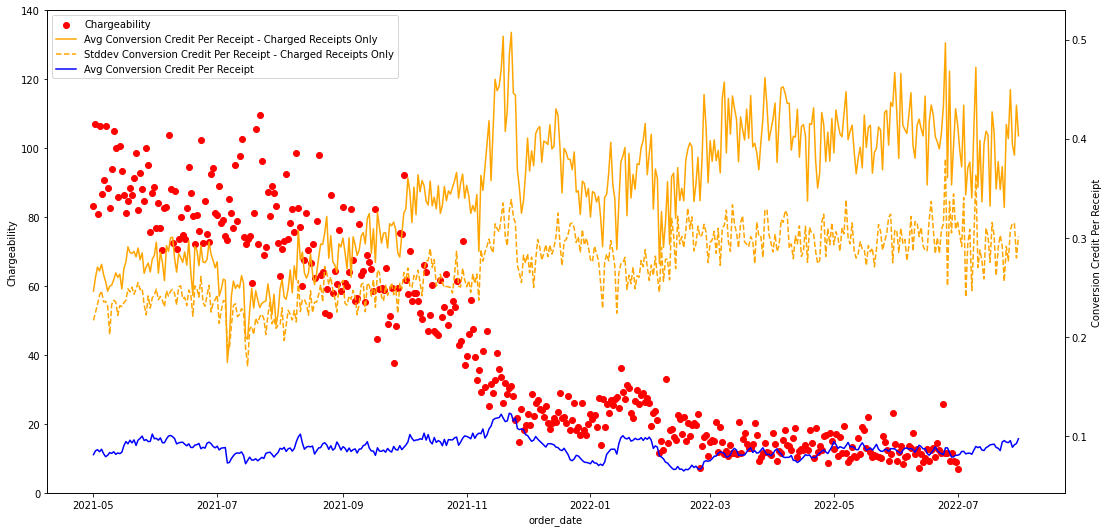

Paid Social - Pinterest - Paid


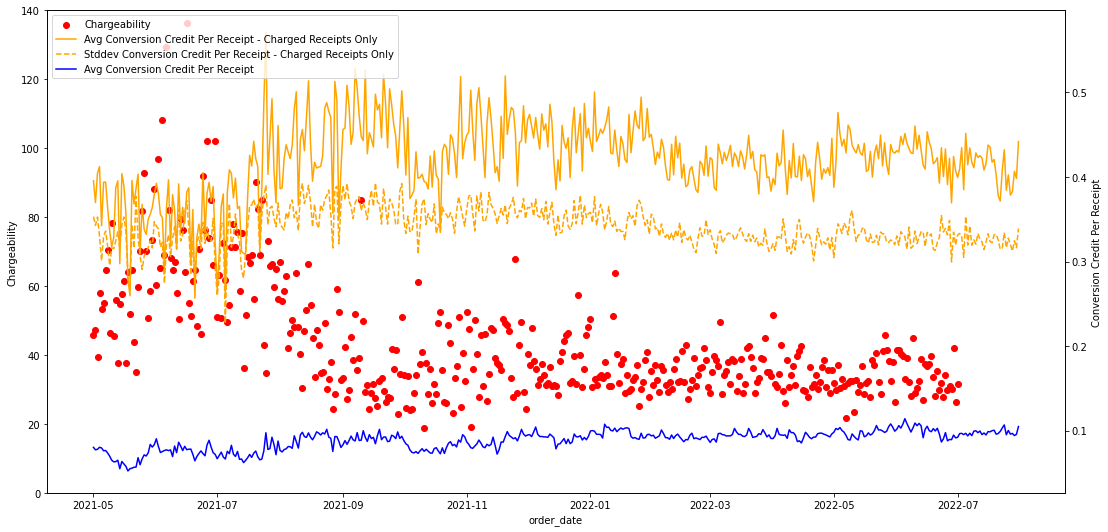

In [575]:
#Display/Pinterest Decel in 2021
#Chargeability vs Avg Channel Credit
#SHOW

plt.rcParams["figure.figsize"] = [15.50, 7.50]
plt.rcParams["figure.autolayout"] = True

for i in ['Display - Google - Paid', 'Paid Social - Pinterest - Paid']:

    viz_data = channel_base_ratio_yoy[(channel_base_ratio_yoy['reporting_channel_group_engine'] == i)&(channel_base_ratio_yoy['order_date']>= date.today() - relativedelta(months=18))
    &(channel_base_ratio_yoy['order_date'] < date(2022,8,1))&(channel_base_ratio_yoy['order_date'] >= date(2021,5,1))  ]       
    
    viz_data = viz_data.sort_values(by=['reporting_channel_group_engine','order_date'])
    
    print(i)
    
    ax1 = plt.subplot()
    l1 = ax1.scatter(viz_data['order_date'], viz_data['chargeability'], color='red')
    
    ax2 = ax1.twinx()
    l2, = ax2.plot(viz_data['order_date'].array, viz_data['attr_receipt_osa_channel_avg'].array, color='orange')
    l3, = ax2.plot(viz_data['order_date'].array, viz_data['attr_receipt_osa_channel_stddev'].array, color='orange', linestyle = '--')  
    l4, = ax2.plot(viz_data['order_date'].array, viz_data['attr_receipt_avg'].array, color='blue')
    
    plt.legend([l1, l2, l3, l4], ["Chargeability", "Avg Conversion Credit Per Receipt - Charged Receipts Only","Stddev Conversion Credit Per Receipt - Charged Receipts Only","Avg Conversion Credit Per Receipt"], loc='upper left')
        
        # bbox_to_anchor=(1.1, 1.05),
        
    ax1.set_xlabel('order_date')
    ax1.set_ylabel('Chargeability')
    ax2.set_ylabel('Conversion Credit Per Receipt')
    
    ax1.set_ylim([0, 140])

    plt.show()

Display - Google - Paid


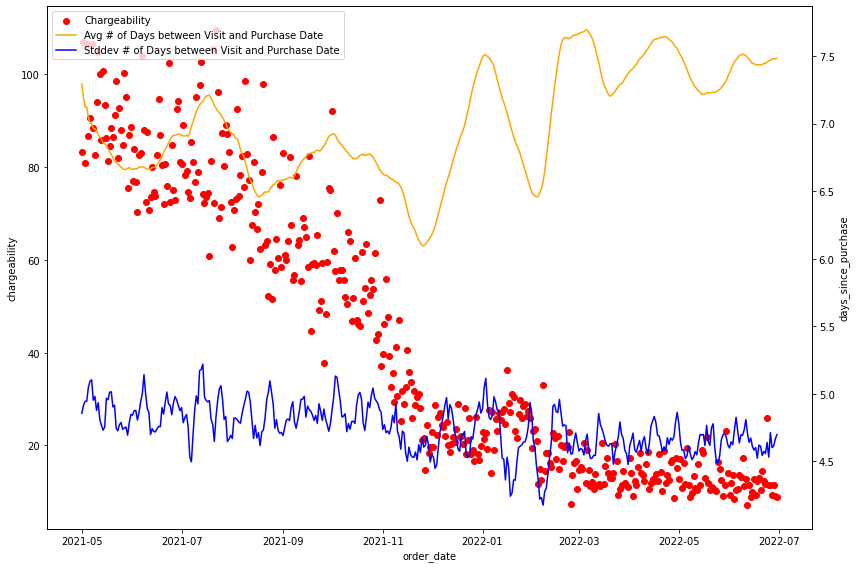

Paid Social - Pinterest - Paid


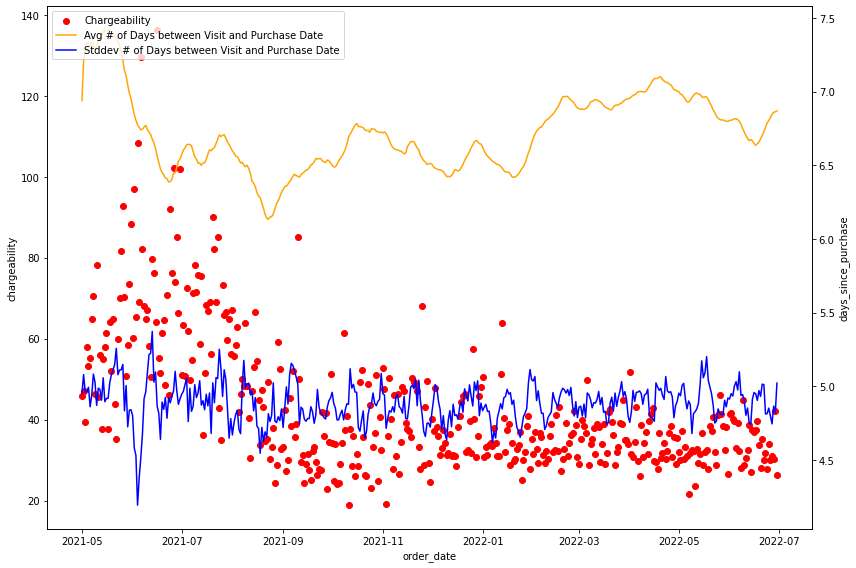

In [579]:
#Display/Pinterest Decel in 2021
#Chargeability vs Days to Purchase
#SHOW

plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["figure.autolayout"] = True

for i in ['Display - Google - Paid', 'Paid Social - Pinterest - Paid']:

    viz_data = channel_base_ratio_yoy[(channel_base_ratio_yoy['reporting_channel_group_engine'] == i)&(channel_base_ratio_yoy['order_date']>= date.today() - relativedelta(months=18))
    &(channel_base_ratio_yoy['order_date'] < date(2022,7,1))&(channel_base_ratio_yoy['order_date'] >= date(2021,5,1))  ]       
    
    viz_data = viz_data.sort_values(by=['reporting_channel_group_engine','order_date'])

    print(i)
    
    viz_data['moving_days_since_purchase_1 - 15'] = viz_data.groupby('reporting_channel_group')['days_since_purchase_1 - 15'].transform(lambda x: x.rolling(30, 1).mean())
    
    ax1 = plt.subplot()
    l1 = ax1.scatter(viz_data['order_date'].array, viz_data['chargeability'].array, color='red')
    
    ax2 = ax1.twinx()
    #l2, = ax2.plot(viz_data['order_date'].array, viz_data['days_since_purchase_1 - 15'].array, color='orange')
    l2, = ax2.plot(viz_data['order_date'].array, viz_data['moving_days_since_purchase_1 - 15'].array, color='orange') 
    l3, = ax2.plot(viz_data['order_date'].array, viz_data['days_since_purchase_stddev_1 - 15'].array, color='blue')
    
    plt.legend([l1, l2,l3], ["Chargeability", "Avg # of Days between Visit and Purchase Date",'Stddev # of Days between Visit and Purchase Date'], loc='upper left')
    
    #bbox_to_anchor=(1.1, 1.05), 
        
    ax1.set_xlabel('order_date')
    ax1.set_ylabel('chargeability')
    ax2.set_ylabel('days_since_purchase')

    plt.show()